<a href="https://colab.research.google.com/github/alicepearse/DL_prac/blob/master/CNN_fashion_MNISTPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

In [2]:
# Load the data
train_dataset = torchvision.datasets.FashionMNIST(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True)

# train_dataset = torchvision.datasets.CIFAR10(
#     root='.',
#     train=True,
#     transform=transform.ToTensor(),
#     download=True)



Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [3]:
train_dataset.data.max()

tensor(255, dtype=torch.uint8)

In [4]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [5]:
train_dataset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [6]:
test_dataset = torchvision.datasets.FashionMNIST(
    
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True)

In [7]:
# number of classes
K = len(set(train_dataset.targets.numpy()))
print("number of classes:", K)

number of classes: 10


In [9]:
# Define the model
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__()
    # define conv layers
    self.conv_layers = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3, stride=2),
        nn.ReLU()
    )
    self.dense_layers = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(128*2*2, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, K)
    )
    
  def forward(self, X):
    out = self.conv_layers(X)
    out = out.view(out.size(0), -1)
    out = self.dense_layers(out)
    return out


In [10]:
# Instantiate the model
model = CNN(K)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [12]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [13]:
# Data loader
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

In [14]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss)

    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}')

  return train_losses, test_losses

In [16]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, epochs=15)

Epoch 1/15, Train Loss: 0.6406, Test Loss: 0.4863, Duration: 0:00:28.422976
Epoch 2/15, Train Loss: 0.4262, Test Loss: 0.4194, Duration: 0:00:29.033958
Epoch 3/15, Train Loss: 0.3714, Test Loss: 0.3921, Duration: 0:00:28.810674
Epoch 4/15, Train Loss: 0.3371, Test Loss: 0.3581, Duration: 0:00:29.114587
Epoch 5/15, Train Loss: 0.3092, Test Loss: 0.3353, Duration: 0:00:29.115702
Epoch 6/15, Train Loss: 0.2842, Test Loss: 0.3352, Duration: 0:00:29.377596
Epoch 7/15, Train Loss: 0.2682, Test Loss: 0.3205, Duration: 0:00:29.127359
Epoch 8/15, Train Loss: 0.2478, Test Loss: 0.3097, Duration: 0:00:28.756181
Epoch 9/15, Train Loss: 0.2345, Test Loss: 0.3159, Duration: 0:00:29.038151
Epoch 10/15, Train Loss: 0.2190, Test Loss: 0.3088, Duration: 0:00:28.986889
Epoch 11/15, Train Loss: 0.2081, Test Loss: 0.3116, Duration: 0:00:29.298312
Epoch 12/15, Train Loss: 0.1974, Test Loss: 0.3199, Duration: 0:00:29.613189
Epoch 13/15, Train Loss: 0.1865, Test Loss: 0.3091, Duration: 0:00:28.839460
Epoch 14

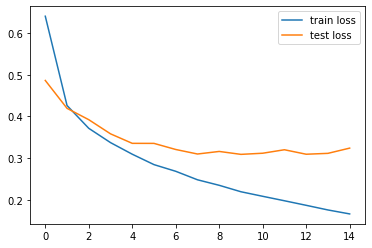

In [17]:
# plot loss
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()

In [19]:
# Evaluate accuracy
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)
  
  # Get  prediction 
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts 
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total

n_correct = 0.
n_total = 0. 
for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # get prediction
  _, prediction = torch.max(outputs, 1)

  # update counts
  n_correct += (prediction == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total

print(f"Train acc: {train_acc: .4f}, Test acc: {test_acc:.4f}")

Train acc:  0.9461, Test acc: 0.8944


In [20]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[886   1  21   9   4   1  72   0   6   0]
 [  2 977   1  13   2   0   2   0   3   0]
 [ 15   0 862  15  41   0  61   0   6   0]
 [ 25  12  13 893  29   0  24   0   4   0]
 [  0   1  70  21 815   1  90   0   2   0]
 [  1   0   0   1   0 976   0  14   3   5]
 [139   2  75  24  76   0 671   0  13   0]
 [  0   0   0   0   0  20   0 956   1  23]
 [  3   0   7   2   2   3   5   1 976   1]
 [  1   0   0   0   0  10   0  43   0 946]]


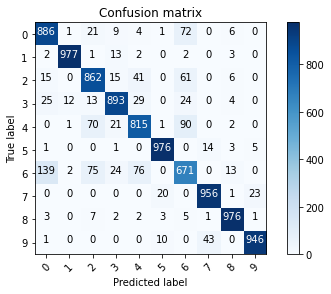

In [21]:
# get all predictions in an array and plot confusion matrix

x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs, 1)
  
  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [22]:
# Label mapping
labels = '''T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot'''.split("\n")

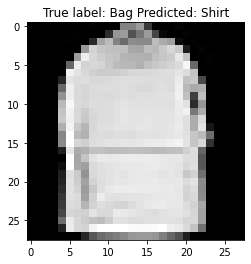

In [23]:
# Show some misclassified examples
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(28,28), cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]));